In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from catboost import Pool, CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import holidays
import optuna

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
urbanbus_data = pd.read_csv('../urbanbus_data/SER_0b91_start_aggregated.csv')

df = urbanbus_data.groupby(["Ride_start_datetime", "Bus_Service_Number", "Direction", "Boarding_stop_stn", "Alighting_stop_stn"], as_index=False)["Passenger_Count"].sum()
df['Ride_start_datetime'] = pd.to_datetime(df['Ride_start_datetime'], errors='coerce')
df = df.sort_values('Ride_start_datetime').reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Date range: {df['Ride_start_datetime'].min()} to {df['Ride_start_datetime'].max()}\n")

Total records: 600,672
Date range: 2017-10-01 00:00:00 to 2018-03-31 23:45:00



In [3]:
# Datetime features
df['hour'] = df['Ride_start_datetime'].dt.hour
df['minute'] = df['Ride_start_datetime'].dt.minute
df['day'] = df['Ride_start_datetime'].dt.day
df['dayofweek'] = df['Ride_start_datetime'].dt.dayofweek
df['month'] = df['Ride_start_datetime'].dt.month
df['year'] = df['Ride_start_datetime'].dt.year
df['week_of_year'] = df['Ride_start_datetime'].dt.isocalendar().week

# Cyclic encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Peak hour flags
peak_hours = df.groupby('hour')['Passenger_Count'].sum().nlargest(2).index.tolist()
df['is_peak_hour'] = df['hour'].isin(peak_hours).astype(int)

# Weekend and holiday flag
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
china_holidays = holidays.country_holidays('CN')
df['is_holiday'] = df['Ride_start_datetime'].dt.date.isin(china_holidays).astype(int)

# Route identifier
df['route'] = df['Boarding_stop_stn'] + '_to_' + df['Alighting_stop_stn']
df = df.sort_values(['route', 'Ride_start_datetime']).reset_index(drop=True)

# Lag Features
for lag in [1, 2, 3, 4, 8, 12, 24]:
    df[f'lag_{lag}'] = df.groupby('route')['Passenger_Count'].shift(lag)

for window in [4, 8, 12, 24]:
    df[f'rolling_mean_{window}'] = (
        df.groupby('route')['Passenger_Count']
        .shift(1)
        .rolling(window=window)
        .mean()
    )
    df[f'rolling_std_{window}'] = (
        df.groupby('route')['Passenger_Count']
        .shift(1)
        .rolling(window=window)
        .std()
    )


lag_roll_cols = [col for col in df.columns if col.startswith(('lag_', 'rolling_'))]
df = df.dropna(subset=lag_roll_cols).reset_index(drop=True)

In [4]:
max_date = df['Ride_start_datetime'].max()
cutoff_date = max_date - timedelta(days=27)

train_df = df[df['Ride_start_datetime'] < cutoff_date].copy()
test_df = df[df['Ride_start_datetime'] >= cutoff_date].copy()

print(f"Training Set: {len(train_df):,} records ({train_df['Ride_start_datetime'].min()} to {train_df['Ride_start_datetime'].max()})")
print(f"Test Set: {len(test_df):,} records ({test_df['Ride_start_datetime'].min()} to {test_df['Ride_start_datetime'].max()})")
print(f"Split: {len(train_df)/len(df)*100:.1f}% train / {len(test_df)/len(df)*100:.1f}% test\n")

Training Set: 497,989 records (2017-10-01 16:15:00 to 2018-03-04 23:30:00)
Test Set: 89,785 records (2018-03-04 23:45:00 to 2018-03-31 23:45:00)
Split: 84.7% train / 15.3% test



In [5]:
cat_cols = ['Boarding_stop_stn', 'Alighting_stop_stn']

# All numerical features
num_cols = [
    'hour', 'minute', 'day', 'dayofweek', 'month', 'year', 'week_of_year',
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'is_weekend', 'is_holiday', 'is_peak_hour']

# Add lag and rolling features
lag_roll_cols = [col for col in train_df.columns if col.startswith(('lag_', 'rolling_'))]
num_cols.extend(lag_roll_cols)

# Prepare feature matrices
X_train = train_df[cat_cols + num_cols].copy()
y_train = train_df['Passenger_Count'].copy()
X_test = test_df[cat_cols + num_cols].copy()
y_test = test_df['Passenger_Count'].copy()

print(f"Feature matrices:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Total features: {len(cat_cols + num_cols)}\n")

Feature matrices:
  X_train: (497989, 35)
  X_test: (89785, 35)
  Total features: 35



In [6]:
all_features = cat_cols + num_cols
cat_feature_indices = [all_features.index(col) for col in cat_cols]

train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    verbose=100,
    task_type='CPU',
    boosting_type='Plain',
    bootstrap_type='MVS'
)

print("Training CatBoost model...\n")
model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=False,
    plot=False
)


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.sum(nonzero_idx) == 0:
        return 0.0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / 
                          y_true[nonzero_idx])) * 100

def evaluate_model(model, pool, y_true, set_name):
    y_pred = model.predict(pool)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"\n{set_name} Set:")
    print(f"  MAE:   {mae:.4f}")
    print(f"  RMSE:  {rmse:.4f}")
    print(f"  R²:    {r2:.4f}")
    print(f"  MAPE:  {mape:.2f}%")
    
    return y_pred, {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

print("\n" + "="*70)
print("MODEL PERFORMANCE")
print("="*70)

y_train_pred, train_metrics = evaluate_model(model, train_pool, y_train, "Training")
y_test_pred, test_metrics = evaluate_model(model, test_pool, y_test, "Test")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(15).to_string(index=False))



Training CatBoost model...

0:	learn: 0.5603437	test: 0.5515743	best: 0.5515743 (0)	total: 187ms	remaining: 6m 14s
100:	learn: 0.5405859	test: 0.5298065	best: 0.5298065 (100)	total: 8s	remaining: 2m 30s
200:	learn: 0.5390099	test: 0.5283935	best: 0.5283933 (199)	total: 14.9s	remaining: 2m 12s
300:	learn: 0.5365236	test: 0.5260820	best: 0.5260820 (300)	total: 21.3s	remaining: 2m
400:	learn: 0.5349953	test: 0.5248225	best: 0.5248225 (400)	total: 27.2s	remaining: 1m 48s
500:	learn: 0.5341115	test: 0.5242609	best: 0.5242609 (500)	total: 32.9s	remaining: 1m 38s
600:	learn: 0.5335405	test: 0.5237781	best: 0.5237781 (600)	total: 38.5s	remaining: 1m 29s
700:	learn: 0.5332227	test: 0.5236044	best: 0.5236044 (700)	total: 44.1s	remaining: 1m 21s
800:	learn: 0.5327494	test: 0.5233088	best: 0.5233088 (800)	total: 50s	remaining: 1m 14s
900:	learn: 0.5321435	test: 0.5228892	best: 0.5228892 (900)	total: 55.9s	remaining: 1m 8s
1000:	learn: 0.5316140	test: 0.5225768	best: 0.5225768 (1000)	total: 1m 1s	r


Visualization saved as 'model_performance.png'


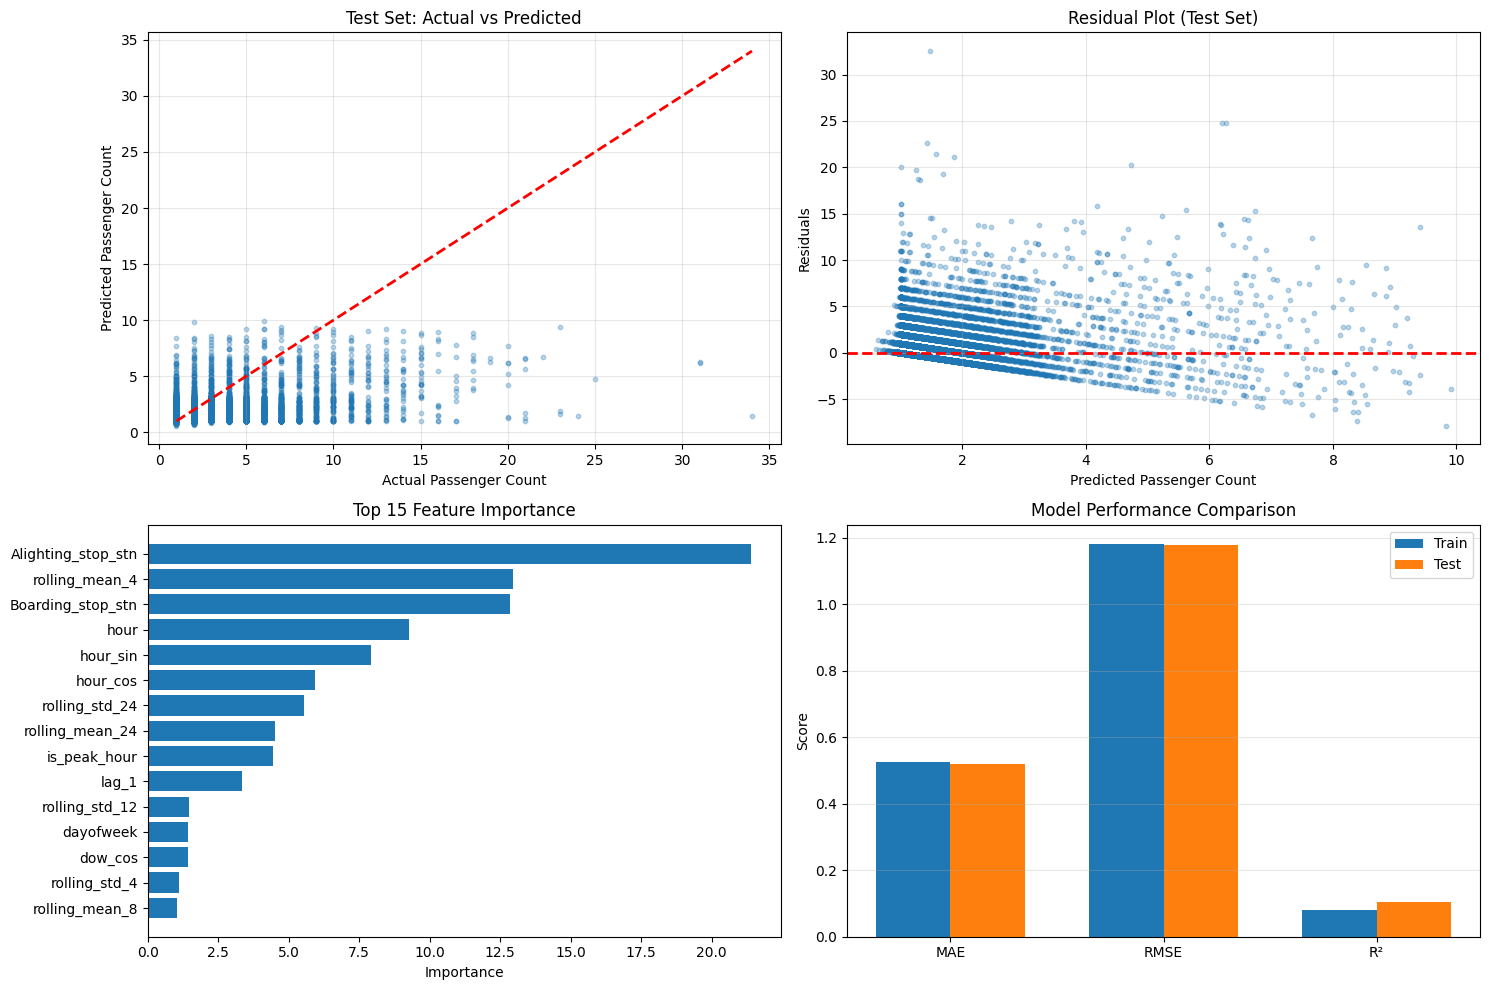

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2)
axes[0, 0].set_xlabel('Actual Passenger Count')
axes[0, 0].set_ylabel('Predicted Passenger Count')
axes[0, 0].set_title('Test Set: Actual vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Passenger Count')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot (Test Set)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature Importance
top_features = feature_importance.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['importance'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Feature Importance')
axes[1, 0].invert_yaxis()

# 4. Performance Comparison
metrics_df = pd.DataFrame({
    'Train': [train_metrics['MAE'], train_metrics['RMSE'], train_metrics['R2']],
    'Test': [test_metrics['MAE'], test_metrics['RMSE'], test_metrics['R2']]
}, index=['MAE', 'RMSE', 'R²'])

x = np.arange(len(metrics_df.index))
width = 0.35
axes[1, 1].bar(x - width/2, metrics_df['Train'], width, label='Train')
axes[1, 1].bar(x + width/2, metrics_df['Test'], width, label='Test')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_df.index)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as 'model_performance.png'")

plt.show()